In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad, trapezoid
import pandas as pd

# simulate

In [2]:
N_sim = int(100e3)
dt = 1e-4
dB = np.sqrt(dt)

V_A_old = 0.4
V_A_new = 0.6
a_old = 2
a_new = 1.5

t_LED = 1

RT_all_sim = np.zeros((N_sim))


In [3]:
def simulate_single_bound_V_A_change(V_A_old, V_A_new, a_old, a_new, t_LED, dt):
    t = 0
    DV = 0

    is_due_to_LED = 0

    while True:
        if t >= t_LED:
            v = V_A_new
            a = a_new
        else:
            v = V_A_old
            a = a_old
        
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        
        if DV >= a:
            if t <= t_LED + 2*dt and t >= t_LED - 2*dt and DV >= a_new:
                is_due_to_LED = 1

            return t, is_due_to_LED
        

sim_results = Parallel(n_jobs=-1)(delayed(simulate_single_bound_V_A_change)\
                                  (V_A_old, V_A_new, a_old, a_new, t_LED, dt) for _ in tqdm(range(N_sim)))
is_led_all_res = np.array([res[1] for res in sim_results])
print(f"Fraction of LED-induced events: {np.mean(is_led_all_res)}")

100%|██████████| 100000/100000 [01:32<00:00, 1079.18it/s]


Fraction of LED-induced events: 0.04995


(0.0, 15.0)

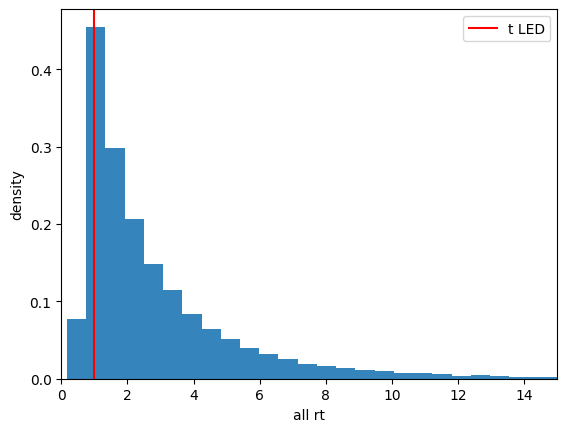

In [10]:
all_rt = [res[0] for res in sim_results]
plt.hist(all_rt, bins=100, alpha=0.9, density=True)
plt.axvline(x=t_LED, label='t LED', color='r')
plt.legend()
plt.xlabel('all rt')
plt.ylabel('density')
plt.xlim(0,15)

# pdf

In [5]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def P_t_x(x, t, v, a):
    """
    Prob that DV = x at time t given v, a 
    """
    return (1/np.sqrt(2 * (np.pi) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )


def P_old_at_x_times_P_new_hit(x, t, V_A_old, V_A_new, a_old, a_new, t_LED):
    """
    Prob that DV is at x at t_LED and new V_A hits "a-x" bound at t - t_LED
    t is surely > t_LED
    """
    if x <= a_new:
        return P_t_x(x, t_LED, V_A_old, a_old) * rho_A_t_fn(t-t_LED, V_A_new, a_new - x)
    else:
        return 0  



def PDF_hit_V_A_change(t, V_A_old, V_A_new, a_old, a_new, t_LED):
    """
    PDF of RT of hitting single bound with V_A change at t_LED
    """
    if t < t_LED:
        p = rho_A_t_fn(t, V_A_old, a_old)
    elif t == t_LED:
        p = quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0] 
    else:
        p = quad(P_old_at_x_times_P_new_hit, -np.inf, a_new, args=(t, V_A_old, V_A_new, a_old, a_new, t_LED))[0]    
    
    return p

In [6]:
non_led_prob = quad(PDF_hit_V_A_change, 0, np.inf, args=(V_A_old, V_A_new, a_old, a_new, t_LED))[0]
led_prob = quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0]
print(f'Non-LED prob: {non_led_prob:.2f}, LED prob = {led_prob:.2f}, total = {(non_led_prob + led_prob):.2f}')

Non-LED prob: 0.95, LED prob = 0.05, total = 1.00


In [ ]:
# # data
# # bins = np.linspace(0.001, 10, 100)
# bin_width = 0.1
# bins = np.arange(0, 10, bin_width)
# sim_results_hist, _ = np.histogram(sim_results, bins=bins, density=True)
# plt.bar(bins[:-1], sim_results_hist, width=bin_width, alpha=0.5, label='sim data va change');
# # plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label='sim data va change');

# # theory
# t_pts = bins[:-1] + bin_width/2
# theory_pdf = np.array([PDF_hit_V_A_change(t, V_A_old, V_A_new, a_old, a_new, t_LED) for t in t_pts])
# plt.plot(t_pts, theory_pdf, label='theory', lw=2)
# # plt.axvline(x=t_LED, color='red', linestyle='--', label='t_LED', alpha=0.5)
# plt.scatter(t_LED, PDF_hit_V_A_change(t_LED, V_A_old, V_A_new, a_old, a_new, t_LED)/bin_width, color='k', marker='x')
# plt.xlabel('rt')
# plt.ylabel('density')
# plt.legend();


## exclude the t_LED time pts

In [ ]:
bin_width = 0.1; T_max = 50
bins = np.arange(0, T_max, bin_width)
t_pts = bins[:-1] + bin_width/2

rt_non_led = [res[0] for res in sim_results if res[1] == 0]
rt_led = [res[0] for res in sim_results if res[1] == 1]

print(f'len of rt_non_led = {len(rt_non_led)}, len of rt_led = {len(rt_led)}')

In [ ]:
# --- non LED --- 
# data
# ONLY non-led
rt_non_led_hist, _ = np.histogram(rt_non_led, bins=bins, density=True)
rt_non_led_hist *= len(rt_non_led)/N_sim
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_pts, rt_non_led_hist, label='sim data non-led', color='r', ls='--', lw=3)

# ALL
# all_rt = [res[0] for res in sim_results]
# all_rt_hist, _ = np.histogram(all_rt, bins=bins, density=True)
# plt.plot(t_pts, all_rt_hist, label='sim data all', color='b')

# theory
area_under_non_led = quad(PDF_hit_V_A_change, 0, T_max, args=(V_A_old, V_A_new, a_old, a_new, t_LED))[0]
theory_pdf_non_led = np.array([PDF_hit_V_A_change(t, V_A_old, V_A_new, a_old, a_new, t_LED) for t in t_pts])
plt.plot(t_pts, theory_pdf_non_led, label='theory non-led', color='k', lw=1.5)


print(f'non - led area = {area_under_non_led:.4f}')
print(f'area under non-led theory curve = {trapezoid(theory_pdf_non_led, t_pts):.4f}')
print(f'area under histogram = {trapezoid(rt_non_led_hist, t_pts):.4f}')
print(f'frac from data = {(len(rt_non_led)/N_sim):.4f}')

plt.subplot(1,2,2)
plt.plot(t_pts, rt_non_led_hist - theory_pdf_non_led, label='data - theory')
plt.xlabel('t')
plt.title(f'hist - theory. bin width={bin_width}')



plt.xlabel('rt')
plt.ylabel('density')
plt.legend();
plt.xlim(0, 15);

In [ ]:
# --- LED ---
# data
bin_width = 0.001; T_max = 5
bins = np.arange(0, T_max, bin_width)
t_pts = bins[:-1] + bin_width/2

rt_led_hist, _ = np.histogram(rt_led, bins=bins, density=True)
rt_led_hist *= len(rt_led)/N_sim

plt.plot(t_pts, rt_led_hist, label='led data')

# theory
prob_of_abort_at_t_led = PDF_hit_V_A_change(t_LED, V_A_old, V_A_new, a_old, a_new, t_LED)
plt.scatter(t_LED, prob_of_abort_at_t_led /bin_width, color='r', marker='x', label='theory LED',s=200)

plt.xlabel('t')
plt.ylabel('density')
plt.legend();

print(f'Frac of aborts at t_LED: theory = {prob_of_abort_at_t_led}, data = {len(rt_led)/N_sim}')
           